# Recruit Restaurant Visitor Forecasting
## Team Members : 
* Apoorv Panse
* Deepti Chawda
* Shahbaz Khan

# Project Overview

Recruit Holdings has unique access to key datasets that could make automated future customer predictions possible. Specifically, Recruit Holdings owns Hot Pepper Gourmet (a restaurant review service), AirREGI (a restaurant point of sales service), and Restaurant Board (reservation log management software).

* This project aims to to use reservation and visitation data to predict the total number of visitors to a restaurant for future dates. This information will help restaurants be much more efficient and allow them to focus on creating an enjoyable dining experience for their customers.
* The datasets contain daily and hourly observations. This makes it a __Time Series Forecasting problem.__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 50)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set(color_codes=True)

# Air Reserve CSV Analysis

__air_reserve__

Column Name | Column Description
-------------|:------------------
air_store_id | restaurant id in the air system
visit_datetime| time of the reservation
reserve_datetime | time the reservation was made
reserve_visitors | number of visitors for that reservation

In [3]:
air_reserve = pd.read_csv('air_reserve.csv')

In [4]:
air_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   air_store_id      92378 non-null  object
 1   visit_datetime    92378 non-null  object
 2   reserve_datetime  92378 non-null  object
 3   reserve_visitors  92378 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


* We have total 92378 rows in the table with 4 columns. 
* Visit Dates and Reserve Dates are currently object data types, which needs to be converted to __data time format__. 

In [5]:
#Reimporting the air_reserve csv using pandas inbuilt date time format parsing.
air_reserve = air_reserve = pd.read_csv('air_reserve.csv',parse_dates=['visit_datetime', 'reserve_datetime'])

In [6]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [7]:
air_reserve.tail()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
92373,air_db4b38ebe7a7ceff,2017-05-29 18:00:00,2017-04-17 19:00:00,6
92374,air_1033310359ceeac1,2017-05-30 23:00:00,2017-04-19 17:00:00,8
92375,air_877f79706adbfb06,2017-05-31 20:00:00,2017-04-12 23:00:00,3
92376,air_900d755ebd2f7bbd,2017-05-31 20:00:00,2017-04-19 16:00:00,10
92377,air_3cad29d1a23209d2,2017-05-31 21:00:00,2017-04-22 10:00:00,3


In [8]:
air_reserve.describe()

,reserve_visitors
count,92378.00
mean,4.48
std,4.92
min,1.00
25%,2.00
50%,3.00
75%,5.00
max,100.00


* We have atleast 1 visitor for all rows. 
* Maximum visitors count is much higher than the mean visitors count. 
* We have data from 2016-01-01 19:00:00 and end date is 2017-05-31 21:00:00

In [9]:
air_reserve.visit_datetime.is_monotonic

True

The rows are __sorted by visit date__ time column.

In [10]:
air_reserve.isnull().values.any()

False

There are __no null__ values in the table 

In [11]:
print('Number of unique restaurants in the air_reserve table : ', len(air_reserve['air_store_id'].unique()))

Number of unique restaurants in the air_reserve table :  314


In [12]:
air_reserve["visit_year"] = pd.DatetimeIndex(air_reserve['visit_datetime']).year
air_reserve["visit_month"] = pd.DatetimeIndex(air_reserve['visit_datetime']).month
air_reserve["visit_weekday"] = pd.DatetimeIndex(air_reserve['visit_datetime']).weekday
air_reserve["visit_date"] = pd.DatetimeIndex(air_reserve['visit_datetime']).date
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_year,visit_month,visit_weekday,visit_date
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016,1,4,2016-01-01
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016,1,4,2016-01-01
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016,1,4,2016-01-01
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016,1,4,2016-01-01
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016,1,4,2016-01-01


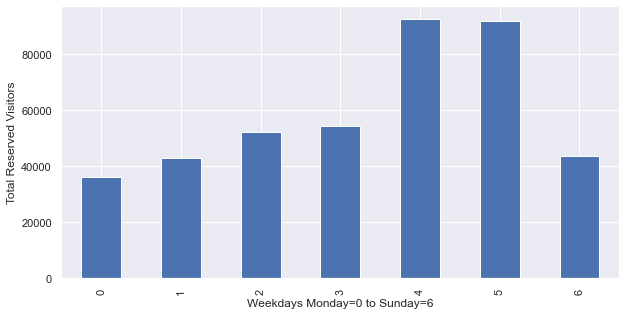

In [13]:
temp = air_reserve.groupby('visit_weekday')['reserve_visitors'].sum()
temp.plot(kind='bar',xlabel = "Weekdays Monday=0 to Sunday=6",ylabel="Total Reserved Visitors",figsize=(10,5))
plt.show()

* There are usually more number of visitors on Fridays and Saturdays

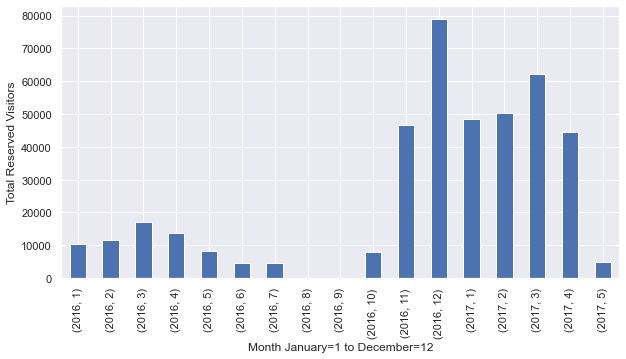

In [14]:
temp = air_reserve.groupby(['visit_year','visit_month'])['reserve_visitors'].sum()
temp.plot(kind='bar',xlabel = "Month January=1 to December=12",ylabel="Total Reserved Visitors",figsize=(10,5))
plt.show()

* There is a certain jump in total visits after November 2016
* Missing values in Dates.

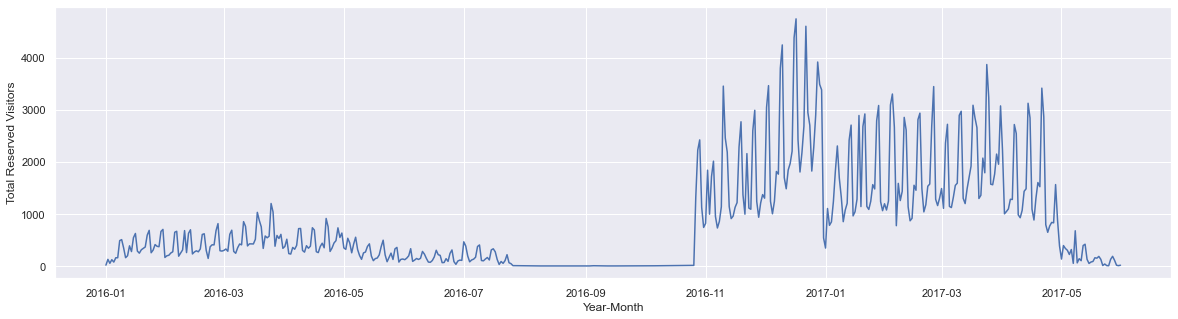

In [15]:
temp = air_reserve.groupby('visit_date')['reserve_visitors'].sum()
temp.plot(kind='line',xlabel="Year-Month",ylabel="Total Reserved Visitors",figsize=(20,5))
plt.show()

* There is an unusual dip during 2017-01

# Air Store Info CSV Analysis

__air_store_info.csv__

Column Name | Column Description
-------------|:------------------
air_store_id | restaurant id in the air system
air_genre_name | genre in the air system
air_area_name | area of the restaurant in the air system
latitude | latitude
longitude | longitude

In [16]:
air_store_info = pd.read_csv('air_store_info.csv')

In [17]:
air_store_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   air_store_id    829 non-null    object 
 1   air_genre_name  829 non-null    object 
 2   air_area_name   829 non-null    object 
 3   latitude        829 non-null    float64
 4   longitude       829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


In [18]:
air_store_info

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.70,135.20
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.70,135.20
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.70,135.20
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.70,135.20
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.66,139.75
...,...,...,...,...,...
824,air_9bf595ef095572fb,International cuisine,Tōkyō-to Shibuya-ku Shibuya,35.66,139.70
825,air_764f71040a413d4d,Asian,Tōkyō-to Shibuya-ku Shibuya,35.66,139.70
826,air_10bbe8acd943d8f6,Asian,Tōkyō-to Shibuya-ku Shibuya,35.66,139.70
827,air_7514d90009613cd6,Karaoke/Party,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.06,141.34


In [19]:
air_store_info.isnull().values.any()

False

In [20]:
air_store_info['air_store_id'].duplicated().any()

False

In [21]:
print('Number of unique restaurants in the air_store_info table : ', len(air_store_info['air_store_id'].unique()))

Number of unique restaurants in the air_store_info table :  829


* air_store_info file has __no null__ values, data is __clean__ and all air_store_id are __unique__

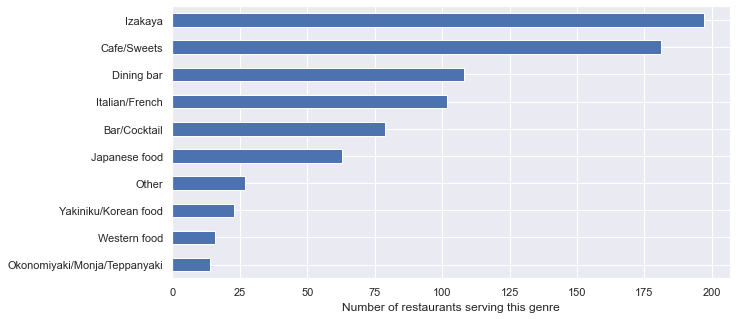

In [22]:
temp = air_store_info['air_genre_name'].value_counts()
temp.nlargest(10).sort_values().plot(kind='barh',figsize=(10,5))
plt.xlabel("Number of restaurants serving this genre")
plt.show()

* Above is the ordering of top 10 __popular food genres__

In [23]:
air_store_info.air_area_name.value_counts()

Fukuoka-ken Fukuoka-shi Daimyō     64
Tōkyō-to Shibuya-ku Shibuya        58
Tōkyō-to Minato-ku Shibakōen       51
Tōkyō-to Shinjuku-ku Kabukichō     39
Tōkyō-to Setagaya-ku Setagaya      30
                                   ..
Tōkyō-to Fuchū-shi Miyanishichō     2
Tōkyō-to Setagaya-ku Kitazawa       2
Ōsaka-fu Suita-shi Izumichō         2
Tōkyō-to Shibuya-ku Dōgenzaka       2
Ōsaka-fu Ōsaka-shi Kyōmachibori     2
Name: air_area_name, Length: 103, dtype: int64

In [24]:
air_store_info['city'] = air_store_info['air_area_name'].str.split().str[0]
air_store_info['ward'] = air_store_info['air_area_name'].str.split().str[1]
air_store_info['neighborhood'] = air_store_info['air_area_name'].str.split().str[2]
air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude,city,ward,neighborhood
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.70,135.20,Hyōgo-ken,Kōbe-shi,Kumoidōri
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.70,135.20,Hyōgo-ken,Kōbe-shi,Kumoidōri
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.70,135.20,Hyōgo-ken,Kōbe-shi,Kumoidōri
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.70,135.20,Hyōgo-ken,Kōbe-shi,Kumoidōri
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.66,139.75,Tōkyō-to,Minato-ku,Shibakōen


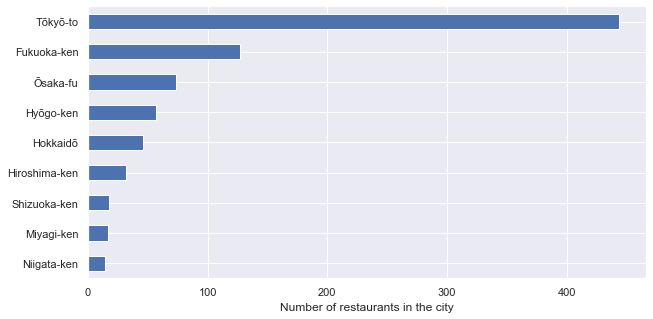

In [25]:
temp = air_store_info['city'].value_counts()
temp.sort_values().plot(kind='barh',figsize=(10,5))
plt.xlabel("Number of restaurants in the city")
plt.show()

* City with most number of restaurants is Tokyo, Fukuoka, Osaka

# Date Info CSV Analysis

__date_info.csv__

Column Name | Column Description
-------------|:------------------
calendar_date | date
day_of_week | day of the week
holiday_flg | if the day is a holiday in Japan

In [26]:
date_info = pd.read_csv('date_info.csv')

In [27]:
date_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   calendar_date  517 non-null    object
 1   day_of_week    517 non-null    object
 2   holiday_flg    517 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 12.2+ KB


In [28]:
date_info.calendar_date = pd.to_datetime(date_info.calendar_date)

In [29]:
date_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [30]:
date_info.holiday_flg.value_counts()

0    482
1     35
Name: holiday_flg, dtype: int64

* It is not yet clear if __holiday flag__ means restaurants are closed that day, or if restaurants are open and chances are there would be more crowd on holidays
* There are __35 Holidays__ in the span of our timeseries

In [31]:
date_info.isnull().values.any()

False

* There are __no null values__ in the table.

# HPG Reserve CSV Analysis

__hpg_reserve.csv__

Column Name | Column Description
-------------|:------------------
hpg_store_id | restaurant id in the hpg system
visit_datetime| time of the reservation
reserve_datetime | time the reservation was made
reserve_visitors | number of visitors for that reservation

In [32]:
hpg_reserve = pd.read_csv('hpg_reserve.csv')

In [33]:
hpg_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000320 entries, 0 to 2000319
Data columns (total 4 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   hpg_store_id      object
 1   visit_datetime    object
 2   reserve_datetime  object
 3   reserve_visitors  int64 
dtypes: int64(1), object(3)
memory usage: 61.0+ MB


* We have total __2000320__ rows in the table with 4 columns. 
* Visit Dates and Reserve Dates are currently object data types, which needs to be converted to __data time format__. 

In [34]:
#Reimporting the hpg_reserve csv using pandas inbuilt date time format parsing.
hpg_reserve = hpg_reserve = pd.read_csv('hpg_reserve.csv',parse_dates=['visit_datetime', 'reserve_datetime'])

In [35]:
hpg_reserve

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13
...,...,...,...,...
2000315,hpg_2b293477ea4642fb,2017-05-31 20:00:00,2017-04-19 07:00:00,2
2000316,hpg_f922aeca48ca5a29,2017-05-31 20:00:00,2017-03-19 00:00:00,3
2000317,hpg_e9151de687b93aa3,2017-05-31 21:00:00,2017-04-14 20:00:00,49
2000318,hpg_fae6c96189b4a122,2017-05-31 21:00:00,2017-04-19 17:00:00,9


In [36]:
hpg_reserve.visit_datetime.is_monotonic

True

In [37]:
hpg_reserve.describe()

,reserve_visitors
count,2000320.00
mean,5.07
std,5.42
min,1.00
25%,2.00
50%,3.00
75%,6.00
max,100.00


* We have atleast 1 reserved visitor for all rows. 
* Maximum visitors count is much higher than the mean visitors count. 
* We have data from 2016-01-01 11:00:00 to 2017-05-31 23:00:00

In [38]:
print('Number of unique restaurants in the hpg_reserve table : ', len(hpg_reserve['hpg_store_id'].unique()))

Number of unique restaurants in the hpg_reserve table :  13325


In [39]:
hpg_reserve["visit_year"] = pd.DatetimeIndex(hpg_reserve['visit_datetime']).year
hpg_reserve["visit_month"] = pd.DatetimeIndex(hpg_reserve['visit_datetime']).month
hpg_reserve["visit_weekday"] = pd.DatetimeIndex(hpg_reserve['visit_datetime']).weekday
hpg_reserve["visit_date"] = pd.DatetimeIndex(hpg_reserve['visit_datetime']).date
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_year,visit_month,visit_weekday,visit_date
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,2016,1,4,2016-01-01
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2016,1,4,2016-01-01
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2,2016,1,4,2016-01-01
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5,2016,1,4,2016-01-01
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13,2016,1,4,2016-01-01


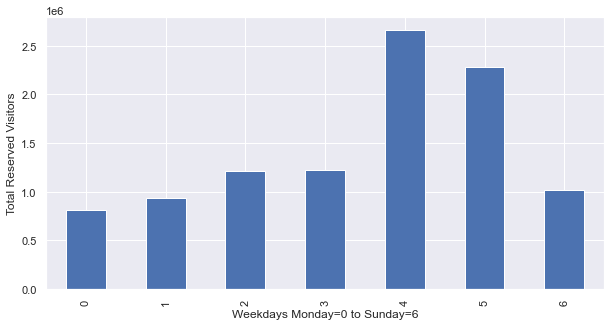

In [40]:
temp = hpg_reserve.groupby('visit_weekday')['reserve_visitors'].sum()
temp.plot(kind='bar',xlabel = "Weekdays Monday=0 to Sunday=6",ylabel="Total Reserved Visitors",figsize=(10,5))
plt.show()

* Similar to AIR Reserve, Friday saturdays haved higher number of reserved visitors in HPG data as well.

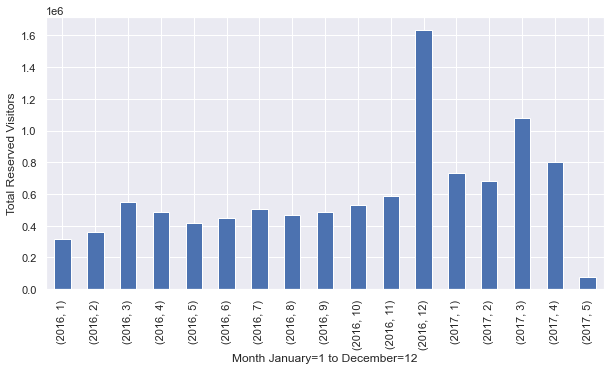

In [41]:
temp = hpg_reserve.groupby(['visit_year','visit_month'])['reserve_visitors'].sum()
temp.plot(kind='bar',xlabel = "Month January=1 to December=12",ylabel="Total Reserved Visitors",figsize=(10,5))
plt.show()

* Unlike AIR reserve data, here we can see some consistent data till November 2016 and then there is sudden jump after that.

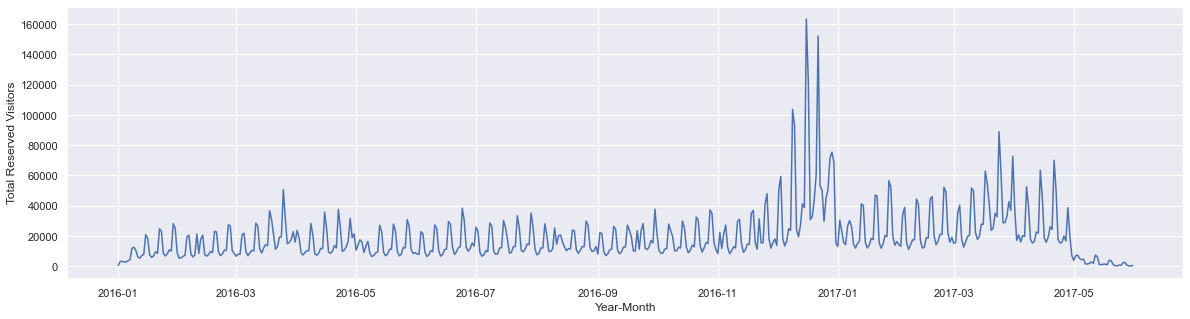

In [42]:
temp = hpg_reserve.groupby('visit_date')['reserve_visitors'].sum()
temp.plot(kind='line',xlabel="Year-Month",ylabel="Total Reserved Visitors",figsize=(20,5))
plt.show()

* Similar to AIR Data, there is sudden increase in total number of reserved visitor at the end of year 2016.

# HPG Store Info

__hpg_store_info.csv__

Column Name | Column Description
-------------|:------------------
hpg_store_id | restaurant id in the hpg system
hpg_genre_name | genre in the hpg system
hpg_area_name | area of the restaurant in the hpg system
latitude | latitude
longitude | longitude


In [43]:
hpg_store_info = pd.read_csv('hpg_store_info.csv')

In [44]:
hpg_store_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hpg_store_id    4690 non-null   object 
 1   hpg_genre_name  4690 non-null   object 
 2   hpg_area_name   4690 non-null   object 
 3   latitude        4690 non-null   float64
 4   longitude       4690 non-null   float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB


In [45]:
hpg_store_info

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67
...,...,...,...,...,...
4685,hpg_c6ed353a48c7c93e,Sichuan food,Tōkyō-to Chiyoda-ku None,35.70,139.77
4686,hpg_a58d2423360b2fb4,Sichuan food,Tōkyō-to Minato-ku Roppongi,35.67,139.73
4687,hpg_d2021704076cdd70,Shanghai food,Tōkyō-to Chiyoda-ku None,35.70,139.77
4688,hpg_602472570d65e219,Spain/Mediterranean cuisine,Tōkyō-to Toshima-ku None,35.73,139.71


In [46]:
hpg_store_info.isnull().values.any()

False

In [47]:
hpg_store_info['hpg_store_id'].duplicated().any()

False

In [48]:
print('Number of unique restaurants in the hpg_store_info table : ', len(hpg_store_info['hpg_store_id'].unique()))

Number of unique restaurants in the hpg_store_info table :  4690


* hpg_store_info file has __no null__ values, data is __clean__ and all hpg_store_id are __unique__

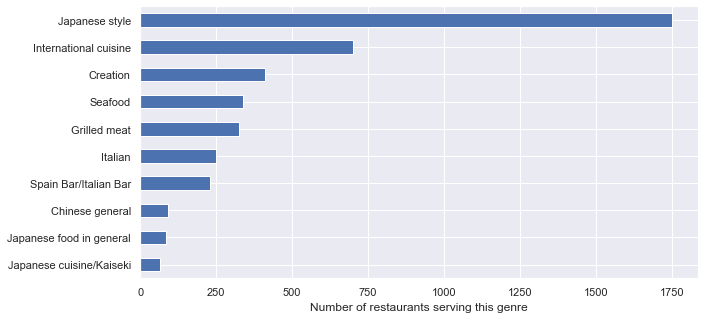

In [49]:
temp = hpg_store_info['hpg_genre_name'].value_counts()
temp.nlargest(10).sort_values().plot(kind='barh',figsize=(10,5))
plt.xlabel("Number of restaurants serving this genre")
plt.show()

* Above is the ordering of top 10 __popular food genres__

In [50]:
hpg_store_info.hpg_area_name.value_counts()

Tōkyō-to Shinjuku-ku None              257
Tōkyō-to Chūō-ku Ginza                 198
Hyōgo-ken Kōbe-shi None                163
Ōsaka-fu Ōsaka-shi Shinsaibashisuji    150
Osaka Prefecture Osaka None            145
                                      ... 
Shizuoka-ken Itō-shi Ogi                 2
Ōsaka-fu Minoo-shi Hanjo                 1
Hokkaidō Ashibetsu-shi None              1
Niigata-ken Nagaoka-shi Rokusho          1
Tōkyō-to Shinagawa-ku Koyama             1
Name: hpg_area_name, Length: 119, dtype: int64

In [51]:
hpg_store_info['city'] = hpg_store_info['hpg_area_name'].str.split().str[0]
hpg_store_info['ward'] = hpg_store_info['hpg_area_name'].str.split().str[1]
hpg_store_info['neighborhood'] = hpg_store_info['hpg_area_name'].str.split().str[2]
hpg_store_info.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude,city,ward,neighborhood
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67,Tōkyō-to,Setagaya-ku,Taishidō
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67,Tōkyō-to,Setagaya-ku,Taishidō
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67,Tōkyō-to,Setagaya-ku,Taishidō
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67,Tōkyō-to,Setagaya-ku,Taishidō
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67,Tōkyō-to,Setagaya-ku,Taishidō


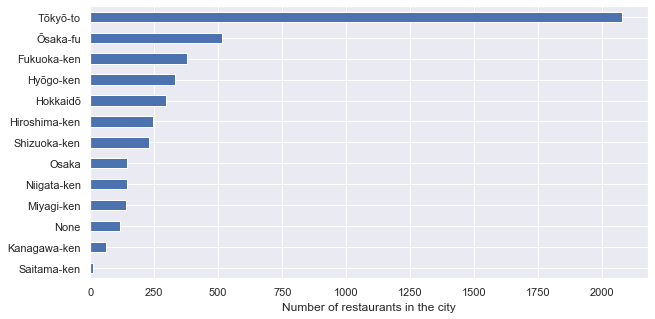

In [52]:
temp = hpg_store_info['city'].value_counts()
temp.sort_values().plot(kind='barh',figsize=(10,5))
plt.xlabel("Number of restaurants in the city")
plt.show()

* City with most number of restaurants is Tokyo, Fukuoka, Osaka

# Store ID Relation

__store_id_relation.csv__

Column Name | Column Description
-------------|:------------------
air_store_id | restaurant id in the air system
hpg_store_id | restaurant id in the hpg system

In [53]:
store_id_relation = pd.read_csv('store_id_relation.csv')
store_id_relation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   air_store_id  150 non-null    object
 1   hpg_store_id  150 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


In [54]:
store_id_relation

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7
...,...,...
145,air_b8925441167c3152,hpg_0cc0abae3a8b52de
146,air_f8233ad00755c35c,hpg_098e4dd30e54fee6
147,air_6607fe3671242ce3,hpg_1004356dc8ab69ec
148,air_ccd19a5bc5573ae5,hpg_df22bf146d2c7e19


* Store ID relation table contains mapping of restaurant names in AIR and HPG system
* Point to be noted here is, that this relation has only 150 entries. And number of AIR / HPG restaurants are much more than that. So we'll have to be careful while merging these two. 

In [55]:
store_id_relation.isnull().values.any()

False

In [56]:
print('Number of unique air_store_id in table : ', len(store_id_relation['air_store_id'].unique()))
print('Number of unique hpg_store_id in table : ', len(store_id_relation['hpg_store_id'].unique()))

Number of unique air_store_id in table :  150
Number of unique hpg_store_id in table :  150


* Just to verify if there are no inconsistent mappings.

# Train CSV

__train.csv__

Column Name | Column Description
-------------|:------------------
air_store_id | restaurant id in the air system
visit_date | date
visitors | the number of visitors to the restaurant on the date

In [57]:
train = pd.read_csv('train.csv')

In [58]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239673 entries, 0 to 239672
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   air_store_id  239673 non-null  object
 1   visit_date    239673 non-null  object
 2   visitors      239673 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.5+ MB


In [59]:
train = pd.read_csv('train.csv',parse_dates=['visit_date'])

In [60]:
train.head()

,air_store_id,visit_date,visitors
0,air_e3020992d5fe5dfd,2016-07-01,21
1,air_e3020992d5fe5dfd,2016-07-02,19
2,air_e3020992d5fe5dfd,2016-07-04,8
3,air_e3020992d5fe5dfd,2016-07-05,11
4,air_e3020992d5fe5dfd,2016-07-06,16


In [61]:
print('Number of unique restaurants in the training data : ', len(train['air_store_id'].unique()))

Number of unique restaurants in the training data :  829


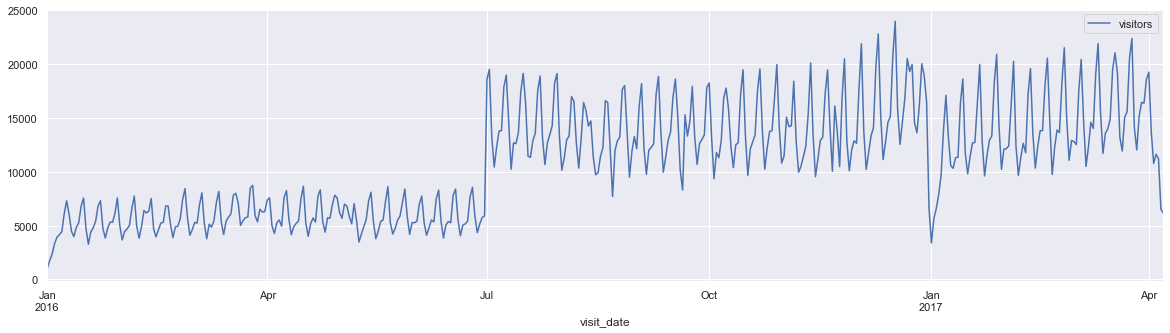

In [62]:
train.groupby('visit_date').sum().plot(figsize=(20,5))
plt.show()

In [63]:
train.isnull().values.any()

False

* There are no null values in training data

In [64]:
pd.Series(list(set(train.air_store_id).intersection(set(store_id_relation.air_store_id))))

0      air_754ae581ad80cc9f
1      air_cfcc94797d2b5d3d
2      air_1c0b150f9e696a5f
3      air_9241121af22ff1d6
4      air_f180301886c21375
               ...         
145    air_37189c92b6c761ec
146    air_90213bcae4afa274
147    air_6e3fd96320d24324
148    air_4433ab8e9999915f
149    air_04cae7c1bc9b2a0b
Length: 150, dtype: object

In [65]:
pd.Series(list(set(air_store_info.air_store_id).intersection(set(store_id_relation.air_store_id))))

0      air_754ae581ad80cc9f
1      air_cfcc94797d2b5d3d
2      air_1c0b150f9e696a5f
3      air_9241121af22ff1d6
4      air_f180301886c21375
               ...         
145    air_37189c92b6c761ec
146    air_90213bcae4afa274
147    air_6e3fd96320d24324
148    air_4433ab8e9999915f
149    air_04cae7c1bc9b2a0b
Length: 150, dtype: object

In [66]:
pd.Series(list(set(air_store_info.air_store_id).intersection(set(train.air_store_id))))

0      air_e2208a79e2678432
1      air_77488fa378cf98c3
2      air_ecab54b57a71b10d
3      air_32f5d7cd696e3c4a
4      air_3525f11ef0bf0c35
               ...         
824    air_b7fa3d2fca744dd2
825    air_81bd68142db76f58
826    air_bf21b8350771879b
827    air_1e23210b584540e7
828    air_77dfc83450cbc89c
Length: 829, dtype: object

* As our training data contains all the air_store_id that are present in store_id_relation, we would need to merge all hpg data from hpg_reserve corresponding to these air_store_id in air_reserve data.

# Sample Submission CSV

In [67]:
sample_submission = pd.read_csv('sample_submission.csv')

In [68]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12435 entries, 0 to 12434
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        12435 non-null  object
 1   visitors  12435 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 194.4+ KB


In [69]:
sample_submission

,id,visitors
0,air_e3020992d5fe5dfd_2017-04-06,0
1,air_e3020992d5fe5dfd_2017-04-07,0
2,air_e3020992d5fe5dfd_2017-04-08,0
3,air_e3020992d5fe5dfd_2017-04-10,0
4,air_e3020992d5fe5dfd_2017-04-11,0
...,...,...
12430,air_4ce7b17062a1bf73_2017-04-18,0
12431,air_4ce7b17062a1bf73_2017-04-19,0
12432,air_4ce7b17062a1bf73_2017-04-20,0
12433,air_4ce7b17062a1bf73_2017-04-21,0


In [70]:
#Extracting air store id from sample submission and checking if all id are present in our training data set.
pd.DataFrame(sample_submission.id.str.rsplit('_',1))['id'].str[0].isin(train.air_store_id).all()

True

* All the air store id present in Sample Submission csv are present in Training data
* This means we have data to predict visitors for every restaurant in sample submission and there are no missing restaurants in training set or metadata

## Next task is to merge the metadata with the training data set, and to collectively analyse the information (EDA) and identifying important features to keep for training a model

General intuition for important features that might be useful for prediction : 
* Month, weekday
* Type of cuisine genre served by restaurant (Genre)
* City / Area / Ward
* holiday flag
* Number of reservations made in advance vs number of actual visitors

In [71]:
#Importing CSV Files
air_reserve = pd.read_csv('air_reserve.csv',parse_dates=['visit_datetime', 'reserve_datetime'])
hpg_reserve = pd.read_csv('hpg_reserve.csv',parse_dates=['visit_datetime', 'reserve_datetime'])
air_store_info = pd.read_csv('air_store_info.csv')
hpg_store_info = pd.read_csv('hpg_store_info.csv')
store_id_relation = pd.read_csv('store_id_relation.csv')
date_info = pd.read_csv('date_info.csv',parse_dates=['calendar_date'])
train = pd.read_csv('train.csv',parse_dates=['visit_date'])
sample_submission = pd.read_csv('sample_submission.csv')

In [72]:
#dropping the day of week column as we would already extract it from datetime value.
date_info.drop(columns=['day_of_week'],inplace=True)

In [73]:
#renaming date column so that it will be useful while merging the holiday flag with training data.
date_info.rename(columns={'calendar_date':'visit_date'},inplace=True)
date_info

,visit_date,holiday_flg
0,2016-01-01,1
1,2016-01-02,1
2,2016-01-03,1
3,2016-01-04,0
4,2016-01-05,0
...,...,...
512,2017-05-27,0
513,2017-05-28,0
514,2017-05-29,0
515,2017-05-30,0


In [74]:
#Adding air_store_id column and performing inner join to discard those rows which does not have air_store_id associated with it.
hpg_reserve_storeinfo = hpg_reserve.merge(store_id_relation, how='inner',on='hpg_store_id')
hpg_reserve_storeinfo

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_store_id
0,hpg_878cc70b1abc76f7,2016-01-01 19:00:00,2016-01-01 15:00:00,4,air_db80363d35f10926
1,hpg_878cc70b1abc76f7,2016-01-02 19:00:00,2016-01-02 14:00:00,2,air_db80363d35f10926
2,hpg_878cc70b1abc76f7,2016-01-03 18:00:00,2016-01-02 20:00:00,6,air_db80363d35f10926
3,hpg_878cc70b1abc76f7,2016-01-06 20:00:00,2016-01-04 22:00:00,3,air_db80363d35f10926
4,hpg_878cc70b1abc76f7,2016-01-11 18:00:00,2016-01-11 14:00:00,2,air_db80363d35f10926
...,...,...,...,...,...
28178,hpg_0f78ef8d1e4b23d8,2017-04-01 21:00:00,2017-03-10 20:00:00,2,air_84f6876ff7e83ae7
28179,hpg_0f78ef8d1e4b23d8,2017-04-02 17:00:00,2017-04-02 14:00:00,2,air_84f6876ff7e83ae7
28180,hpg_0f78ef8d1e4b23d8,2017-04-08 19:00:00,2017-04-03 12:00:00,3,air_84f6876ff7e83ae7
28181,hpg_0f78ef8d1e4b23d8,2017-04-08 20:00:00,2017-03-09 07:00:00,4,air_84f6876ff7e83ae7


In [75]:
#Adjusting the columns and making it align with air_reserve table so that it can be appended later.
hpg_reserve_storeinfo = hpg_reserve_storeinfo[['air_store_id','visit_datetime','reserve_datetime','reserve_visitors']]
hpg_reserve_storeinfo

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_db80363d35f10926,2016-01-01 19:00:00,2016-01-01 15:00:00,4
1,air_db80363d35f10926,2016-01-02 19:00:00,2016-01-02 14:00:00,2
2,air_db80363d35f10926,2016-01-03 18:00:00,2016-01-02 20:00:00,6
3,air_db80363d35f10926,2016-01-06 20:00:00,2016-01-04 22:00:00,3
4,air_db80363d35f10926,2016-01-11 18:00:00,2016-01-11 14:00:00,2
...,...,...,...,...
28178,air_84f6876ff7e83ae7,2017-04-01 21:00:00,2017-03-10 20:00:00,2
28179,air_84f6876ff7e83ae7,2017-04-02 17:00:00,2017-04-02 14:00:00,2
28180,air_84f6876ff7e83ae7,2017-04-08 19:00:00,2017-04-03 12:00:00,3
28181,air_84f6876ff7e83ae7,2017-04-08 20:00:00,2017-03-09 07:00:00,4


In [76]:
#Merging Air reservation data and HPG reservation data for all air_store_id that are available in both tables.
#This is basically appending the hpg data after air data. Because each reservation is done separately, we'll combine
#it date wise later.
reservations = air_reserve.append(hpg_reserve_storeinfo)
reservations

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5
...,...,...,...,...
28178,air_84f6876ff7e83ae7,2017-04-01 21:00:00,2017-03-10 20:00:00,2
28179,air_84f6876ff7e83ae7,2017-04-02 17:00:00,2017-04-02 14:00:00,2
28180,air_84f6876ff7e83ae7,2017-04-08 19:00:00,2017-04-03 12:00:00,3
28181,air_84f6876ff7e83ae7,2017-04-08 20:00:00,2017-03-09 07:00:00,4


In [77]:
#Time of booking and time of reservation.
reservations["visit_date"] = pd.DatetimeIndex(reservations['visit_datetime']).date
reservations["visit_time"] = pd.DatetimeIndex(reservations['visit_datetime']).hour
reservations["reserve_time"] = pd.DatetimeIndex(reservations['reserve_datetime']).hour 

#Time difference between planned visit time and booking time.
reservations["Time_Difference"] = (reservations['visit_datetime'] - reservations['reserve_datetime']).dt.seconds / 3600
reservations

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,visit_time,reserve_time,Time_Difference
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,19,16,3.00
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,19,19,0.00
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,19,19,0.00
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,20,16,4.00
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,20,1,19.00
...,...,...,...,...,...,...,...,...
28178,air_84f6876ff7e83ae7,2017-04-01 21:00:00,2017-03-10 20:00:00,2,2017-04-01,21,20,1.00
28179,air_84f6876ff7e83ae7,2017-04-02 17:00:00,2017-04-02 14:00:00,2,2017-04-02,17,14,3.00
28180,air_84f6876ff7e83ae7,2017-04-08 19:00:00,2017-04-03 12:00:00,3,2017-04-08,19,12,7.00
28181,air_84f6876ff7e83ae7,2017-04-08 20:00:00,2017-03-09 07:00:00,4,2017-04-08,20,7,13.00


In [78]:
#Grouping the reservations by air_store_id and date columns because training dataset contains visitors for a 
#restaurant for respective dates.
reservations_by_date = reservations[['air_store_id','visit_date','reserve_visitors']].groupby(['air_store_id','visit_date'],as_index=False).sum()

#Taking the mean of time difference, visit time and reserve time grouped by store id and date.
reservations_by_date['Time_Difference'] = reservations[['air_store_id','visit_date','Time_Difference',]].groupby(['air_store_id','visit_date'],as_index=False).mean()['Time_Difference']
reservations_by_date['visit_time']= reservations[['air_store_id','visit_date','visit_time',]].groupby(['air_store_id','visit_date'],as_index=False).mean()['visit_time']
reservations_by_date['reserve_time']= reservations[['air_store_id','visit_date','reserve_time',]].groupby(['air_store_id','visit_date'],as_index=False).mean()['reserve_time']
reservations_by_date.visit_date = pd.to_datetime(reservations_by_date.visit_date)

reservations_by_date

,air_store_id,visit_date,reserve_visitors,Time_Difference,visit_time,reserve_time
0,air_00a91d42b08b08d9,2016-01-14,2,5.00,19.00,14.00
1,air_00a91d42b08b08d9,2016-01-15,4,22.00,18.00,20.00
2,air_00a91d42b08b08d9,2016-01-16,2,22.00,18.00,20.00
3,air_00a91d42b08b08d9,2016-01-22,2,10.00,18.00,8.00
4,air_00a91d42b08b08d9,2016-01-29,5,0.00,18.00,18.00
...,...,...,...,...,...,...
42188,air_fea5dc9594450608,2017-04-22,4,3.00,22.00,19.00
42189,air_fea5dc9594450608,2017-04-25,4,20.00,18.00,22.00
42190,air_fea5dc9594450608,2017-04-28,6,0.00,19.00,19.00
42191,air_fea5dc9594450608,2017-05-20,12,21.00,19.00,22.00


In [79]:
#adding store info to the training dataset from air_store_info table as it contains data for all the air stores.
train_temp = train.merge(air_store_info, how='left', on='air_store_id')

In [80]:
#preparing final training dataset by merging reservation data to the train data.
train_data = train_temp.merge(reservations_by_date,how='left',on=['air_store_id','visit_date'])

#As we would have many null values, because most of the restaurants in training data set does not have reservation data.
train_data.fillna(value=0,inplace=True)

#We do not require latitude longitude information as we extracted the city ward and neighborhood.
train_data.drop(columns=['latitude','longitude'],inplace=True)

#Extracting year month weekday as new features
train_data["visit_year"] = pd.DatetimeIndex(train_data['visit_date']).year
train_data["visit_month"] = pd.DatetimeIndex(train_data['visit_date']).month
train_data["visit_weekday"] = pd.DatetimeIndex(train_data['visit_date']).weekday

#Extracting city ward neighbourhood as new features
train_data['city'] = train_data['air_area_name'].str.split().str[0]
train_data['ward'] = train_data['air_area_name'].str.split().str[1]
train_data['neighborhood'] = train_data['air_area_name'].str.split().str[2]

#Add holiday flag from date info table
train_data = train_data.merge(date_info,how='left',on='visit_date')

#Making all object type columns as categorical columns so that it may help in plotting.
for col in train_data.columns:
    if train_data[col].dtype == 'object':
        train_data[col] = train_data[col].astype('category')

train_data

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,reserve_visitors,Time_Difference,visit_time,reserve_time,visit_year,visit_month,visit_weekday,city,ward,neighborhood,holiday_flg
0,air_e3020992d5fe5dfd,2016-07-01,21,Italian/French,Tōkyō-to Chūō-ku Tsukiji,0.00,0.00,0.00,0.00,2016,7,4,Tōkyō-to,Chūō-ku,Tsukiji,0
1,air_e3020992d5fe5dfd,2016-07-02,19,Italian/French,Tōkyō-to Chūō-ku Tsukiji,0.00,0.00,0.00,0.00,2016,7,5,Tōkyō-to,Chūō-ku,Tsukiji,0
2,air_e3020992d5fe5dfd,2016-07-04,8,Italian/French,Tōkyō-to Chūō-ku Tsukiji,0.00,0.00,0.00,0.00,2016,7,0,Tōkyō-to,Chūō-ku,Tsukiji,0
3,air_e3020992d5fe5dfd,2016-07-05,11,Italian/French,Tōkyō-to Chūō-ku Tsukiji,0.00,0.00,0.00,0.00,2016,7,1,Tōkyō-to,Chūō-ku,Tsukiji,0
4,air_e3020992d5fe5dfd,2016-07-06,16,Italian/French,Tōkyō-to Chūō-ku Tsukiji,0.00,0.00,0.00,0.00,2016,7,2,Tōkyō-to,Chūō-ku,Tsukiji,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239668,air_4ce7b17062a1bf73,2017-03-30,15,Italian/French,Tōkyō-to Minato-ku Shibakōen,0.00,0.00,0.00,0.00,2017,3,3,Tōkyō-to,Minato-ku,Shibakōen,0
239669,air_4ce7b17062a1bf73,2017-03-31,14,Italian/French,Tōkyō-to Minato-ku Shibakōen,0.00,0.00,0.00,0.00,2017,3,4,Tōkyō-to,Minato-ku,Shibakōen,0
239670,air_4ce7b17062a1bf73,2017-04-01,9,Italian/French,Tōkyō-to Minato-ku Shibakōen,0.00,0.00,0.00,0.00,2017,4,5,Tōkyō-to,Minato-ku,Shibakōen,0
239671,air_4ce7b17062a1bf73,2017-04-03,11,Italian/French,Tōkyō-to Minato-ku Shibakōen,0.00,0.00,0.00,0.00,2017,4,0,Tōkyō-to,Minato-ku,Shibakōen,0


In [81]:
#Just cross checking if all the restaurants in submission csv in present in our training dataset or not.
pd.DataFrame(sample_submission.id.str.rsplit('_',1))['id'].str[0].isin(train_data.air_store_id).all()

True

In [82]:
train_data.columns

Index(['air_store_id', 'visit_date', 'visitors', 'air_genre_name',
       'air_area_name', 'reserve_visitors', 'Time_Difference', 'visit_time',
       'reserve_time', 'visit_year', 'visit_month', 'visit_weekday', 'city',
       'ward', 'neighborhood', 'holiday_flg'],
      dtype='object')

In [83]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239673 entries, 0 to 239672
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   air_store_id      239673 non-null  category      
 1   visit_date        239673 non-null  datetime64[ns]
 2   visitors          239673 non-null  int64         
 3   air_genre_name    239673 non-null  category      
 4   air_area_name     239673 non-null  category      
 5   reserve_visitors  239673 non-null  float64       
 6   Time_Difference   239673 non-null  float64       
 7   visit_time        239673 non-null  float64       
 8   reserve_time      239673 non-null  float64       
 9   visit_year        239673 non-null  int64         
 10  visit_month       239673 non-null  int64         
 11  visit_weekday     239673 non-null  int64         
 12  city              239673 non-null  category      
 13  ward              239673 non-null  category      
 14  neig

In [84]:
#Converting numeric values into categories so that encodings can be applied later.
for col in ['visit_year','visit_month','visit_weekday','holiday_flg']:
    train_data[col] = train_data[col].astype('category')

In [85]:
train_data.sort_values(by='visit_date').head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,reserve_visitors,Time_Difference,visit_time,reserve_time,visit_year,visit_month,visit_weekday,city,ward,neighborhood,holiday_flg
119146,air_b2d8bc9c88b85f96,2016-01-01,16,Dining bar,Fukuoka-ken Fukuoka-shi Tenjin,0.00,0.00,0.00,0.00,2016,1,4,Fukuoka-ken,Fukuoka-shi,Tenjin,1
79537,air_536043fcf1a4f8a4,2016-01-01,42,Bar/Cocktail,Ōsaka-fu Ōsaka-shi Kyūtarōmachi,0.00,0.00,0.00,0.00,2016,1,4,Ōsaka-fu,Ōsaka-shi,Kyūtarōmachi,1
105397,air_a083834e7ffe187e,2016-01-01,27,Izakaya,Miyagi-ken Sendai-shi Kamisugi,0.00,0.00,0.00,0.00,2016,1,4,Miyagi-ken,Sendai-shi,Kamisugi,1
77925,air_db4b38ebe7a7ceff,2016-01-01,21,Dining bar,Ōsaka-fu Ōsaka-shi Shinmachi,9.00,0.00,19.00,19.00,2016,1,4,Ōsaka-fu,Ōsaka-shi,Shinmachi,1
158788,air_70e9e8cd55879414,2016-01-01,4,Bar/Cocktail,Tōkyō-to Shibuya-ku Dōgenzaka,0.00,0.00,0.00,0.00,2016,1,4,Tōkyō-to,Shibuya-ku,Dōgenzaka,1


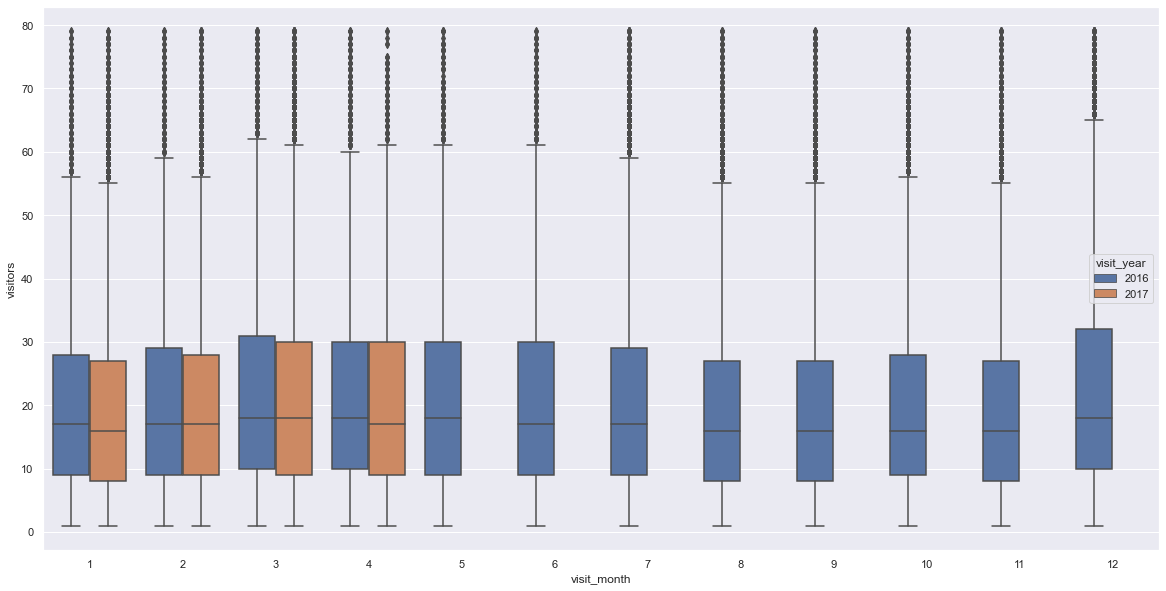

In [86]:
plt.figure(figsize=(20,10))
sns.boxplot(y='visitors',x='visit_month',data=train_data[(train_data.visitors < 80)],hue='visit_year')
plt.show()


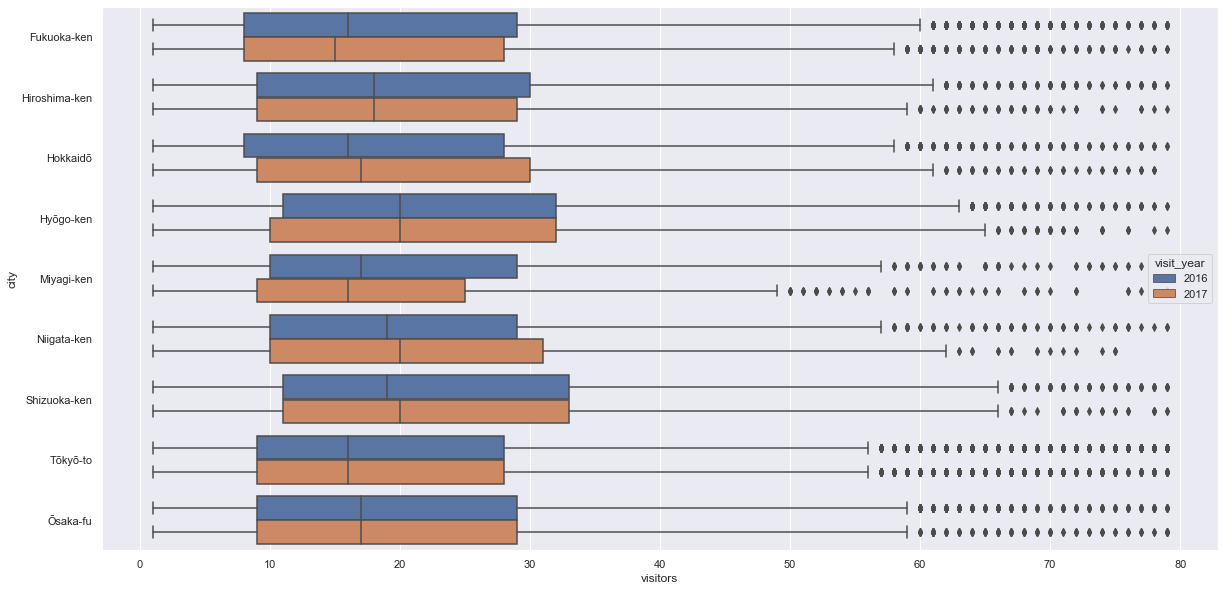

In [87]:
plt.figure(figsize=(20,10))
sns.boxplot(x='visitors',y='city',data=train_data[(train_data.visitors < 80)],hue='visit_year')
plt.show()

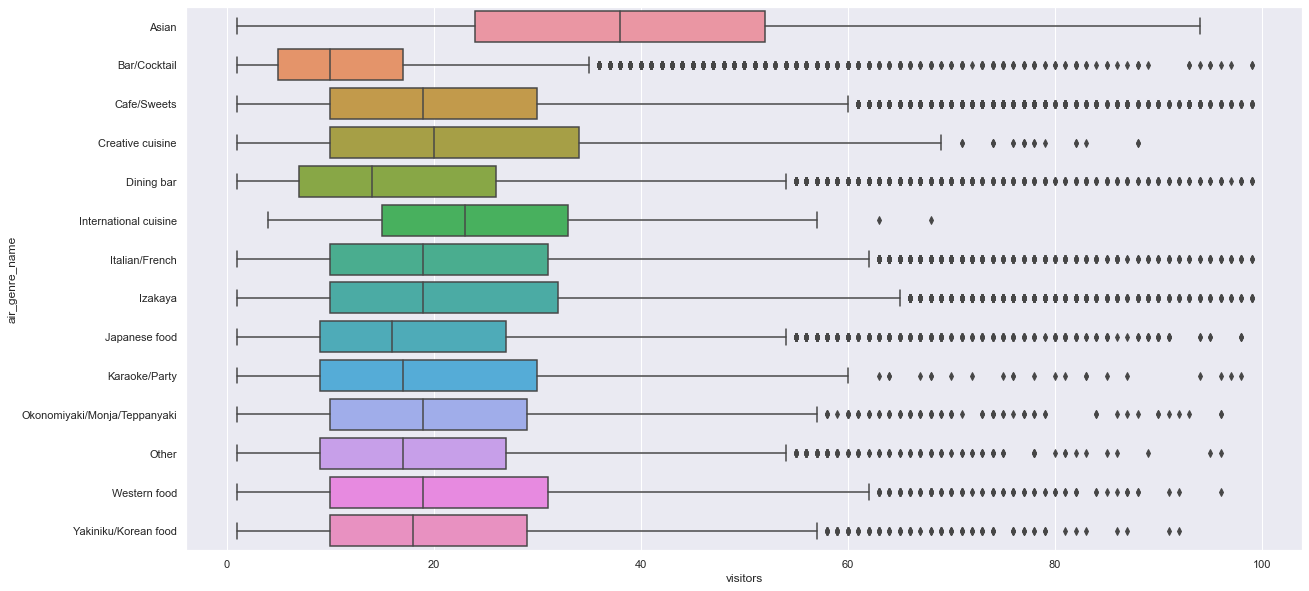

In [88]:
plt.figure(figsize=(20,10))
sns.boxplot(x='visitors',y='air_genre_name',data=train_data[(train_data.visitors < 100)])
plt.show()

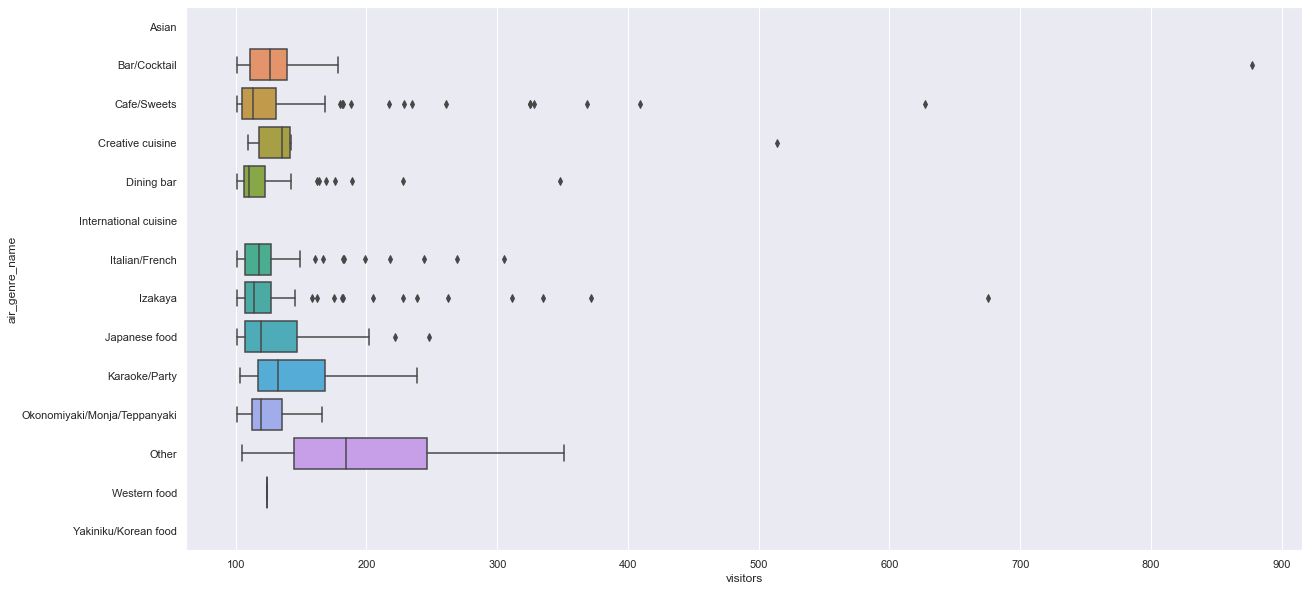

In [89]:
plt.figure(figsize=(20,10))
sns.boxplot(x='visitors',y='air_genre_name',data=train_data[(train_data.visitors > 100)])
plt.show()

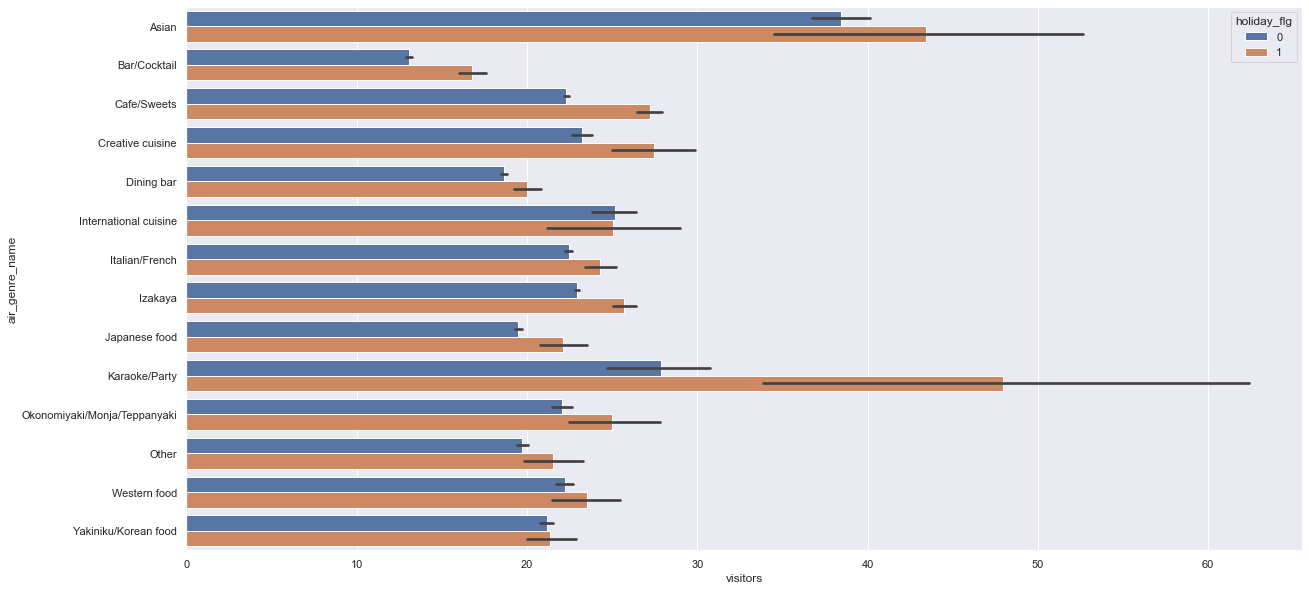

In [90]:
plt.figure(figsize=(20,10))
sns.barplot(x='visitors',y='air_genre_name',data=train_data,hue='holiday_flg')
plt.show()

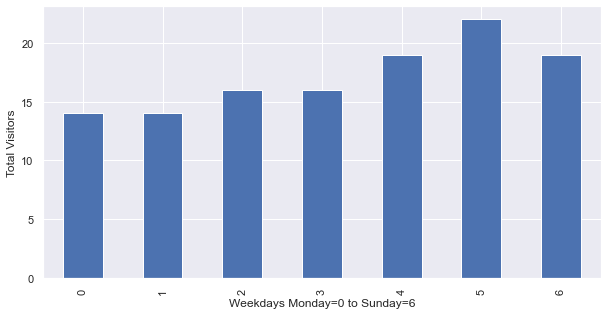

In [91]:
temp = train_data.groupby('visit_weekday')['visitors'].median()
temp.plot(kind='bar',xlabel = "Weekdays Monday=0 to Sunday=6",ylabel="Total Visitors",figsize=(10,5))
plt.show()

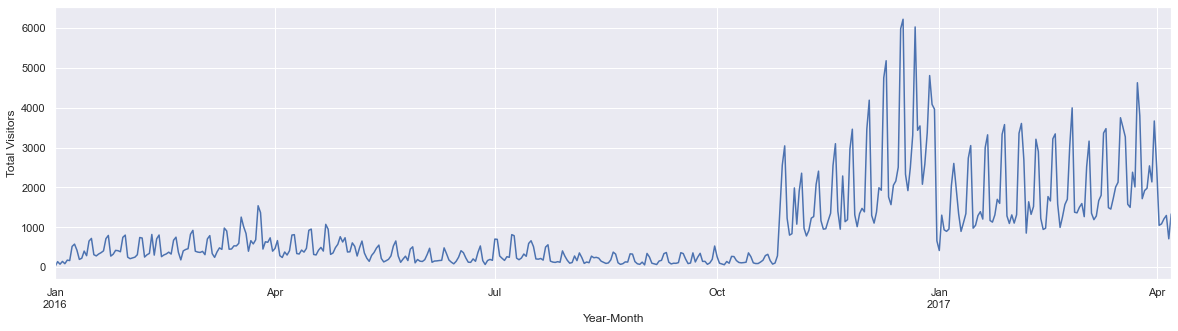

In [92]:
temp = train_data.groupby('visit_date')['reserve_visitors'].sum()
temp.plot(kind='line',xlabel="Year-Month",ylabel="Total Visitors",figsize=(20,5))
plt.show()

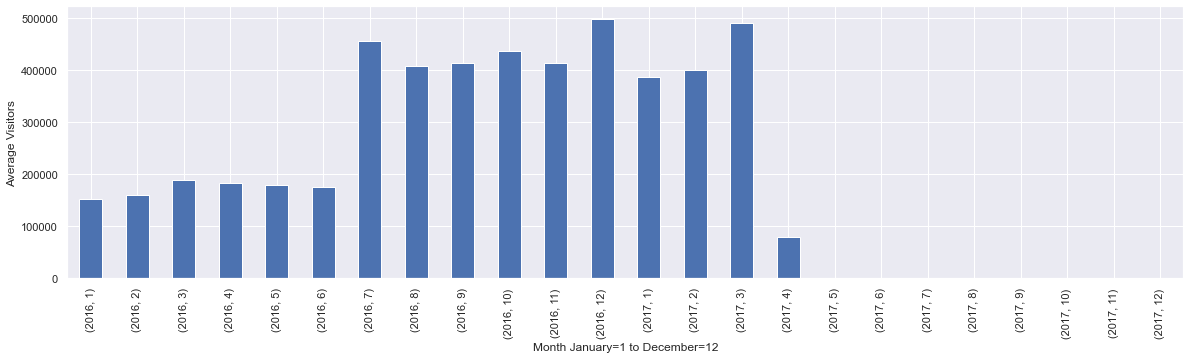

In [93]:
temp = train_data.groupby(['visit_year','visit_month'])['visitors'].sum()
temp.plot(kind='bar',xlabel = "Month January=1 to December=12",ylabel="Average Visitors",figsize=(20,5))
plt.show()

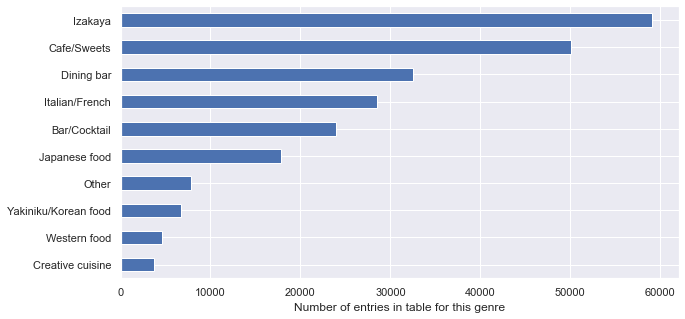

In [94]:
temp = train_data['air_genre_name'].value_counts()
temp.nlargest(10).sort_values().plot(kind='barh',figsize=(10,5))
plt.xlabel("Number of entries in table for this genre")
plt.show()

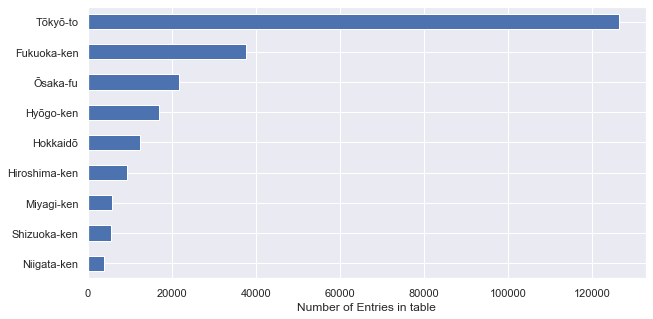

In [95]:
temp = train_data['city'].value_counts()
temp.sort_values().plot(kind='barh',figsize=(10,5))
plt.xlabel("Number of Entries in table")
plt.show()

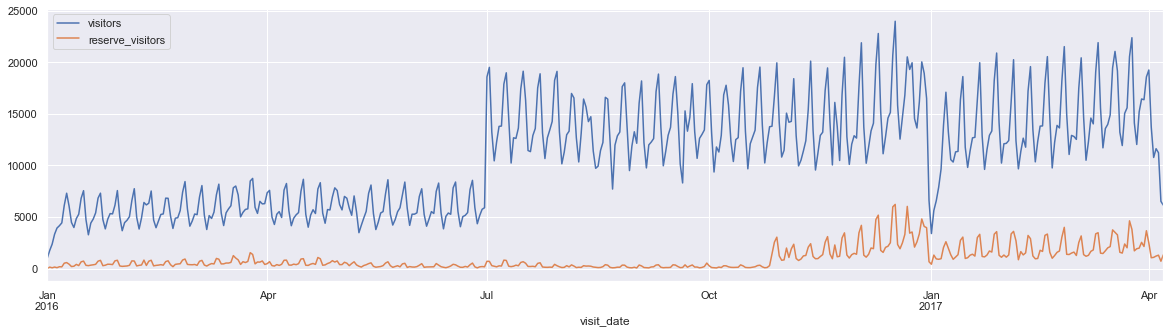

In [96]:
train_data.groupby('visit_date').sum()[['visitors','reserve_visitors']].plot(figsize=(20,5))
plt.show()

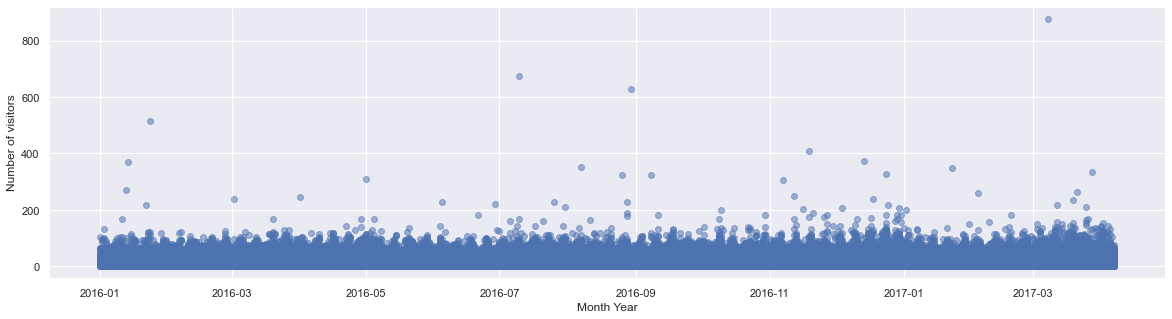

In [97]:
fig, ax = plt.subplots(figsize=(20,5))
ax.scatter(train_data["visit_date"], train_data["visitors"],alpha=0.5)
plt.xlabel("Month Year")
plt.ylabel("Number of visitors")
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


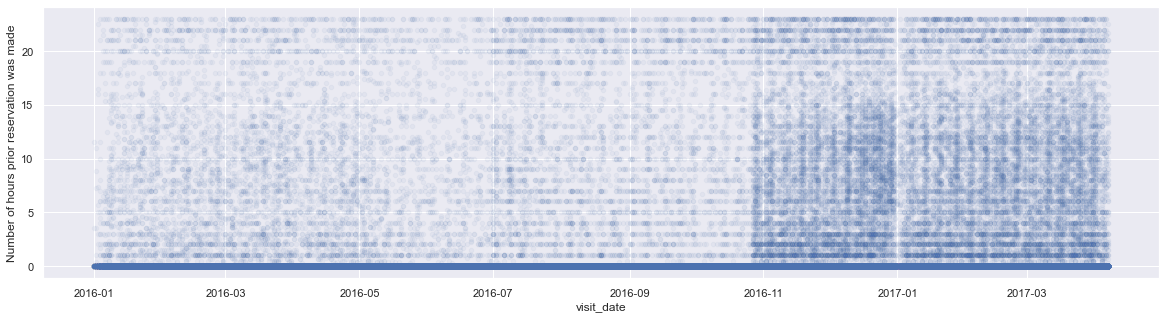

In [98]:
train_data[['visit_date','Time_Difference']].plot(x='visit_date',y='Time_Difference', figsize=(20,5),kind='scatter',alpha = 0.05)
plt.ylabel("Number of hours prior reservation was made")
plt.show()

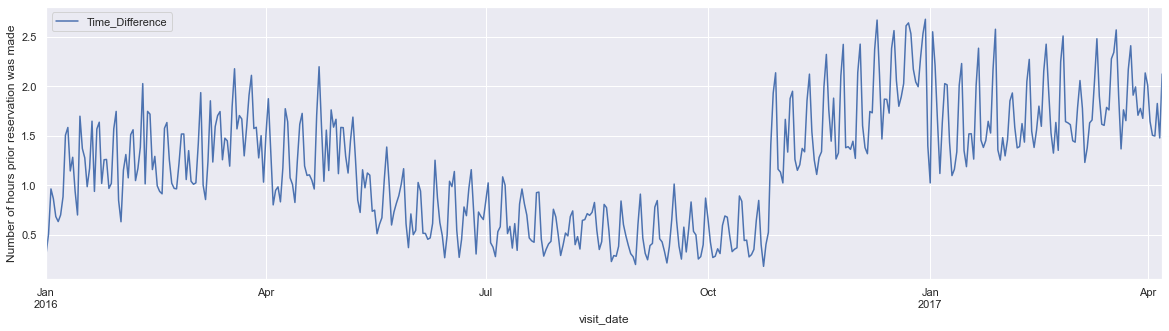

In [99]:
temp =train_data[['visit_date','Time_Difference']].groupby('visit_date').mean().reset_index()
temp.plot(x='visit_date',y='Time_Difference', figsize=(20,5),kind='line')
plt.ylabel("Number of hours prior reservation was made")
plt.show()

In [100]:
train_data

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,reserve_visitors,Time_Difference,visit_time,reserve_time,visit_year,visit_month,visit_weekday,city,ward,neighborhood,holiday_flg
0,air_e3020992d5fe5dfd,2016-07-01,21,Italian/French,Tōkyō-to Chūō-ku Tsukiji,0.00,0.00,0.00,0.00,2016,7,4,Tōkyō-to,Chūō-ku,Tsukiji,0
1,air_e3020992d5fe5dfd,2016-07-02,19,Italian/French,Tōkyō-to Chūō-ku Tsukiji,0.00,0.00,0.00,0.00,2016,7,5,Tōkyō-to,Chūō-ku,Tsukiji,0
2,air_e3020992d5fe5dfd,2016-07-04,8,Italian/French,Tōkyō-to Chūō-ku Tsukiji,0.00,0.00,0.00,0.00,2016,7,0,Tōkyō-to,Chūō-ku,Tsukiji,0
3,air_e3020992d5fe5dfd,2016-07-05,11,Italian/French,Tōkyō-to Chūō-ku Tsukiji,0.00,0.00,0.00,0.00,2016,7,1,Tōkyō-to,Chūō-ku,Tsukiji,0
4,air_e3020992d5fe5dfd,2016-07-06,16,Italian/French,Tōkyō-to Chūō-ku Tsukiji,0.00,0.00,0.00,0.00,2016,7,2,Tōkyō-to,Chūō-ku,Tsukiji,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239668,air_4ce7b17062a1bf73,2017-03-30,15,Italian/French,Tōkyō-to Minato-ku Shibakōen,0.00,0.00,0.00,0.00,2017,3,3,Tōkyō-to,Minato-ku,Shibakōen,0
239669,air_4ce7b17062a1bf73,2017-03-31,14,Italian/French,Tōkyō-to Minato-ku Shibakōen,0.00,0.00,0.00,0.00,2017,3,4,Tōkyō-to,Minato-ku,Shibakōen,0
239670,air_4ce7b17062a1bf73,2017-04-01,9,Italian/French,Tōkyō-to Minato-ku Shibakōen,0.00,0.00,0.00,0.00,2017,4,5,Tōkyō-to,Minato-ku,Shibakōen,0
239671,air_4ce7b17062a1bf73,2017-04-03,11,Italian/French,Tōkyō-to Minato-ku Shibakōen,0.00,0.00,0.00,0.00,2017,4,0,Tōkyō-to,Minato-ku,Shibakōen,0


Text(0, 0.5, 'Mean visitors / Hours')

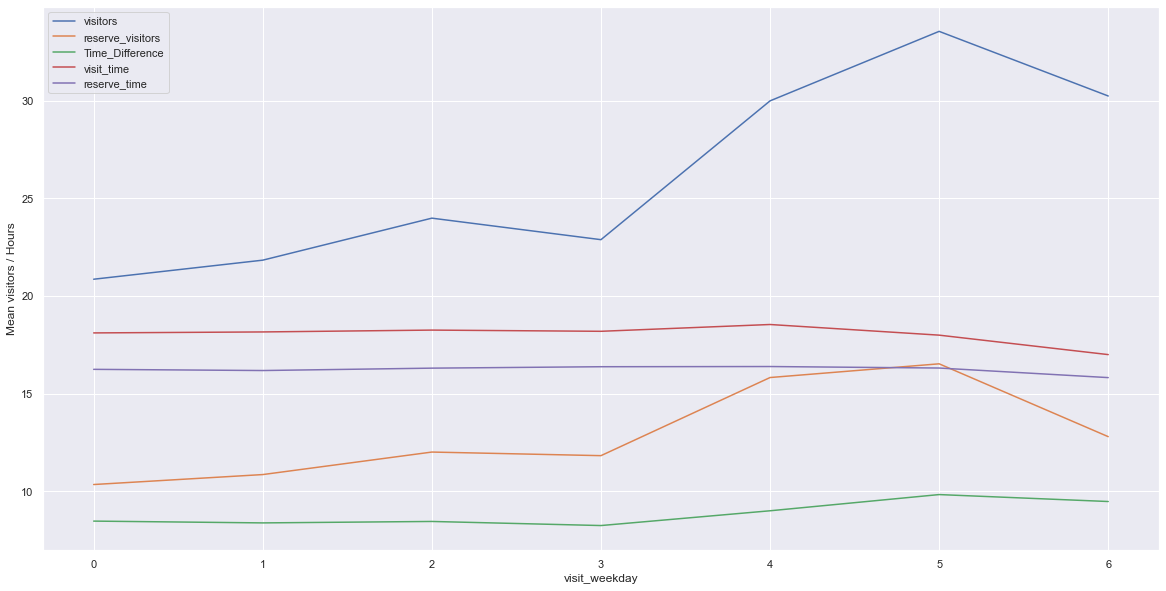

In [101]:
train_data[(train_data.reserve_visitors > 0)].groupby(['visit_weekday']).mean().plot(figsize=(20,10))
plt.ylabel("Mean visitors / Hours")

Text(0, 0.5, 'Mean visitors / Hours')

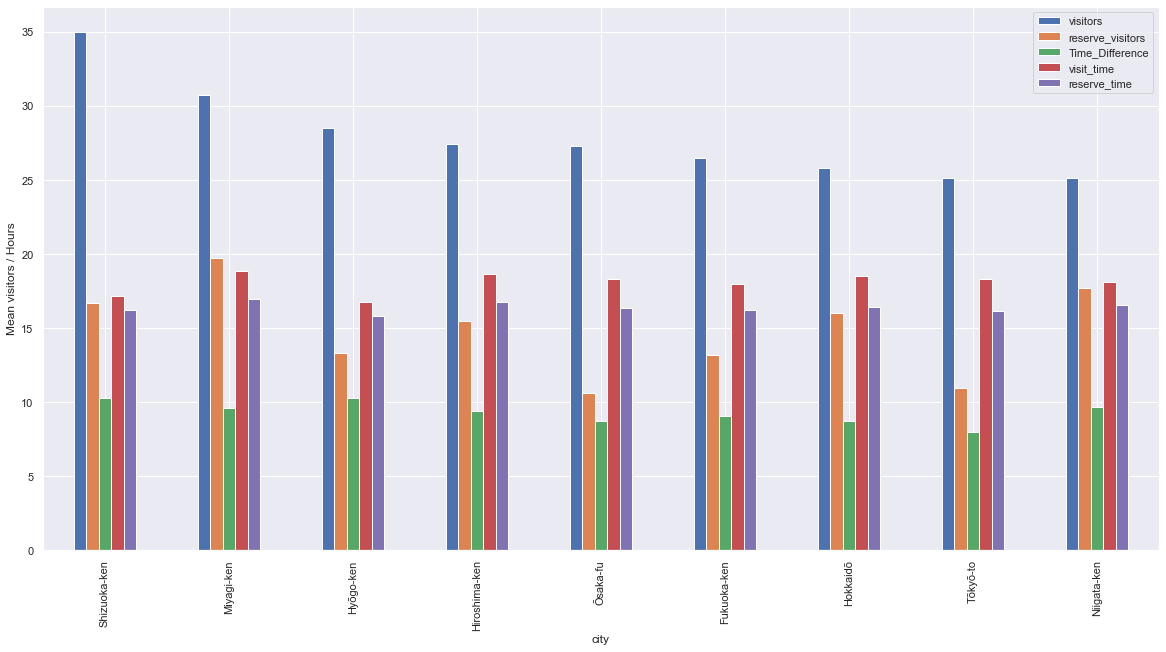

In [102]:
train_data[(train_data.reserve_visitors > 0)].groupby(['city']).mean().sort_values(by='visitors',ascending=False).plot(figsize=(20,10),kind='bar')
plt.ylabel("Mean visitors / Hours")

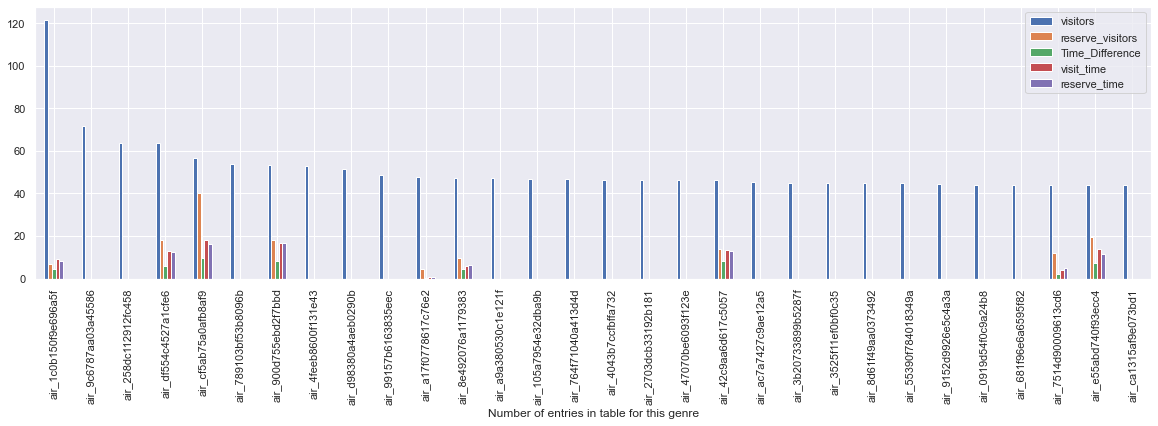

In [103]:
temp = train_data.groupby('air_store_id').mean()
temp.sort_values(by='visitors',ascending=False)[:30].plot(kind='bar',figsize=(20,5))
plt.xlabel("Number of entries in table for this genre")
plt.show()

In [104]:
temp = train_data.groupby('air_store_id').mean()
top10 = temp.sort_values(by='visitors',ascending=False)[:10]
top10

,visitors,reserve_visitors,Time_Difference,visit_time,reserve_time
air_store_id,,,,,
air_1c0b150f9e696a5f,121.69,6.69,4.38,9.06,8.01
air_9c6787aa03a45586,71.80,0.00,0.00,0.00,0.00
air_258dc112912fc458,63.69,0.00,0.00,0.00,0.00
air_df554c4527a1cfe6,63.51,18.11,5.77,12.97,12.35
air_cf5ab75a0afb8af9,56.74,40.05,9.53,17.98,16.19
air_789103bf53b8096b,53.85,0.00,0.00,0.00,0.00
air_900d755ebd2f7bbd,53.20,18.00,8.04,16.85,16.83
air_4feeb8600f131e43,52.77,0.00,0.00,0.00,0.00
air_d98380a4aeb0290b,51.40,0.00,0.00,0.00,0.00


In [105]:
top10 = ['air_1c0b150f9e696a5f','air_9c6787aa03a45586','air_258dc112912fc458','air_df554c4527a1cfe6','air_cf5ab75a0afb8af9', 'air_789103bf53b8096b','air_789103bf53b8096b','air_900d755ebd2f7bbd','air_4feeb8600f131e43','air_d98380a4aeb0290b','air_99157b6163835eec']

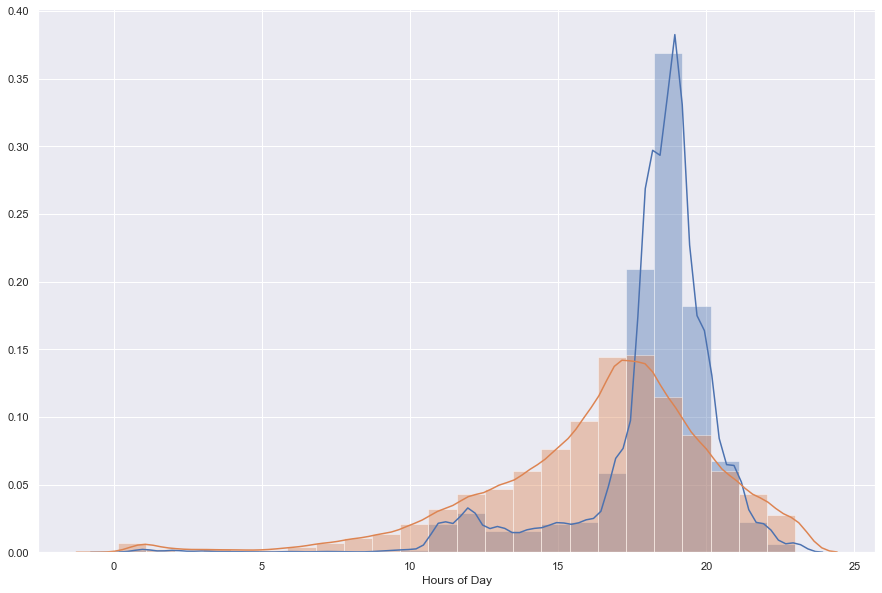

In [106]:
plt.figure(figsize=(15,10))
sns.distplot(train_data[train_data.visit_time > 0].visit_time,bins=24)
sns.distplot(train_data[train_data.reserve_time > 0].reserve_time,bins=24)
plt.xlabel("Hours of Day")
plt.show()

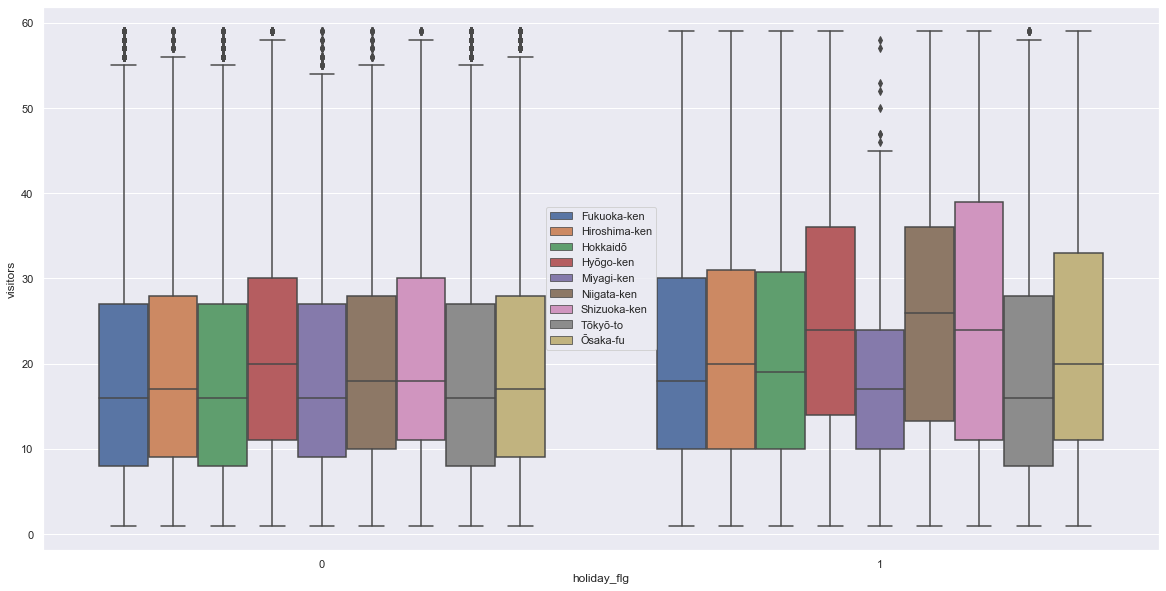

In [107]:
plt.figure(figsize=(20,10))
sns.boxplot(x='holiday_flg', y='visitors', data=train_data[(train_data.visitors<60)],hue='city')
plt.legend(loc='center')
plt.show()

### All important points that were inferred from above plots are listed in Project report pdf in detail. 

# MODEL SELECTION

In [108]:
#Importing CSV Files
air_reserve = pd.read_csv('air_reserve.csv',parse_dates=['visit_datetime', 'reserve_datetime'])
air_store_info = pd.read_csv('air_store_info.csv')
store_id_relation = pd.read_csv('store_id_relation.csv')
date_info = pd.read_csv('date_info.csv',parse_dates=['calendar_date'])
train = pd.read_csv('train.csv',parse_dates=['visit_date'])

In [109]:
#dropping the day of week column as we would already extract it from datetime value.
date_info.drop(columns=['day_of_week'],inplace=True)

#renaming date column so that it will be useful while merging the holiday flag with training data.
date_info.rename(columns={'calendar_date':'visit_date'},inplace=True)

In [110]:
#preparing final training dataset by merging relevant features to the train data.
train_data = train.merge(air_store_info, how='left', on='air_store_id')

#Extracting year month weekday as new features
train_data["visit_year"] = pd.DatetimeIndex(train_data['visit_date']).year
train_data["visit_month"] = pd.DatetimeIndex(train_data['visit_date']).month
train_data["visit_weekday"] = pd.DatetimeIndex(train_data['visit_date']).weekday

#Extracting city ward neighbourhood as new features
train_data['city'] = train_data['air_area_name'].str.split().str[0]
train_data['ward'] = train_data['air_area_name'].str.split().str[1]
train_data['neighborhood'] = train_data['air_area_name'].str.split().str[2]

#Add holiday flag from date info table
train_data = train_data.merge(date_info,how='left',on='visit_date')

#Making all object type columns as categorical columns.
for col in train_data.columns:
    if train_data[col].dtype == 'object':
        train_data[col] = train_data[col].astype('category')
        
#Implementing labelencoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feature in ['city','ward','neighborhood','holiday_flg','air_genre_name','air_area_name']:
    train_data[feature] = le.fit_transform(train_data[feature].astype(str))

    
# #Implementing OneHotEncoding using get dummies method
train_data = pd.concat([train_data,pd.get_dummies(train_data['holiday_flg'], prefix='holiday_flg')],axis=1)
train_data.drop(['holiday_flg'],axis=1, inplace=True)     

In [111]:
#Adding mean median and min max visitors column grouped by air store id and weekday
group_by_cols = ['air_store_id','visit_weekday']
visitor_stats = train_data\
                .groupby(group_by_cols)\
                ['visitors']\
                .agg(['mean', 'median', 'min','max'])\
                .rename(columns=lambda colname: str(colname)+'_visitors')\
                .reset_index()

In [112]:
visitor_stats

,air_store_id,visit_weekday,mean_visitors,median_visitors,min_visitors,max_visitors
0,air_00a91d42b08b08d9,0,22.73,20.00,1.00,47.00
1,air_00a91d42b08b08d9,1,23.58,24.00,1.00,41.00
2,air_00a91d42b08b08d9,2,28.24,28.00,15.00,52.00
3,air_00a91d42b08b08d9,3,29.54,30.00,15.00,47.00
4,air_00a91d42b08b08d9,4,36.46,35.00,20.00,57.00
...,...,...,...,...,...,...
5798,air_fff68b929994bfbd,2,4.67,4.00,1.00,12.00
5799,air_fff68b929994bfbd,3,4.87,5.00,1.00,12.00
5800,air_fff68b929994bfbd,4,5.68,5.00,1.00,17.00
5801,air_fff68b929994bfbd,5,7.61,7.00,2.00,18.00


In [113]:
train_data = train_data.merge(visitor_stats,how='left',on=group_by_cols)

In [114]:
train_data.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,visit_year,visit_month,visit_weekday,city,ward,neighborhood,holiday_flg_0,holiday_flg_1,mean_visitors,median_visitors,min_visitors,max_visitors
0,air_e3020992d5fe5dfd,2016-07-01,21,6,46,35.67,139.77,2016,7,4,7,6,90,1,0,15.93,18.00,3.00,25.00
1,air_e3020992d5fe5dfd,2016-07-02,19,6,46,35.67,139.77,2016,7,5,7,6,90,1,0,13.41,14.00,2.00,30.00
2,air_e3020992d5fe5dfd,2016-07-04,8,6,46,35.67,139.77,2016,7,0,7,6,90,1,0,9.93,10.00,2.00,22.00
3,air_e3020992d5fe5dfd,2016-07-05,11,6,46,35.67,139.77,2016,7,1,7,6,90,1,0,11.16,10.50,2.00,24.00
4,air_e3020992d5fe5dfd,2016-07-06,16,6,46,35.67,139.77,2016,7,2,7,6,90,1,0,12.50,13.00,2.00,20.00


In [115]:
# Create evaluation function (the competition uses Root Mean Square Log Error)
from sklearn.metrics import mean_squared_log_error

def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

In [119]:
#train test split
from sklearn.model_selection import train_test_split
X = train_data.drop(["air_store_id","visit_date","visitors","air_area_name","longitude"], axis=1)
y = train_data["visitors"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [120]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239673 entries, 0 to 239672
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   air_genre_name   239673 non-null  int32  
 1   latitude         239673 non-null  float64
 2   visit_year       239673 non-null  int64  
 3   visit_month      239673 non-null  int64  
 4   visit_weekday    239673 non-null  int64  
 5   city             239673 non-null  int32  
 6   ward             239673 non-null  int32  
 7   neighborhood     239673 non-null  int32  
 8   holiday_flg_0    239673 non-null  uint8  
 9   holiday_flg_1    239673 non-null  uint8  
 10  mean_visitors    239673 non-null  float64
 11  median_visitors  239673 non-null  float64
 12  min_visitors     239673 non-null  float64
 13  max_visitors     239673 non-null  float64
dtypes: float64(5), int32(4), int64(3), uint8(2)
memory usage: 20.6 MB


In [121]:
#Trying simple Linear Regression model

from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_preds=lr_model.predict(X_test)
rmsle(y_test, y_preds)

0.5369255002063672

In [128]:
#train test split with test size 0.1
from sklearn.model_selection import train_test_split
X = train_data.drop(["air_store_id","visit_date","visitors","air_area_name","longitude"], axis=1)
y = train_data["visitors"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [129]:
#Trying KNeighbors Regression model

from sklearn.neighbors import KNeighborsRegressor
knr_model = KNeighborsRegressor(n_jobs=-1, n_neighbors=10)
knr_model.fit(X_train, y_train)
y_preds=knr_model.predict(X_test)
rmsle(y_test, y_preds)

0.5398689672131062

In [130]:
#Trying Random Forest Regressor Regression model 

from sklearn.ensemble import RandomForestRegressor

rfrmodel = RandomForestRegressor(n_estimators=20, n_jobs=-1, 
                                 max_samples=None)

rfrmodel.fit(X_train, y_train)
y_preds=rfrmodel.predict(X_test)
rmsle(y_test, y_preds)

0.5648134039363351

In [124]:
from sklearn.model_selection import GridSearchCV

params_grid = { "n_estimators": [20], 
                 "n_jobs": [-1], 
                "max_samples": [None],
               "min_samples_split": [1,5,10,15],
               "min_samples_leaf": [1,2,3,4,5],
               }
grid_search = GridSearchCV(rfrmodel, params_grid,
                           n_jobs=-1, cv=5,
                           verbose=-1, scoring='neg_mean_squared_log_error')
grid_search.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_estimators=20, n_jobs=-1),
             n_jobs=-1,
             param_grid={'max_samples': [None],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [1, 5, 10, 15],
                         'n_estimators': [20], 'n_jobs': [-1]},
             scoring='neg_mean_squared_log_error', verbose=-1)

In [125]:
grid_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [131]:
#Trying Random Forest Regressor Regression model 

from sklearn.ensemble import RandomForestRegressor

rfrmodel = RandomForestRegressor(n_estimators=200, min_samples_leaf=5,
                                 min_samples_split=15,
                                 max_features=1, n_jobs=-1, 
                                 )

rfrmodel.fit(X_train, y_train)
y_preds=rfrmodel.predict(X_test)
rmsle(y_test, y_preds)

0.5289086869919264

In [134]:
#Trying XGBoost Regression model

from xgboost import XGBRegressor
xgbmodel = XGBRegressor(
                        max_depth =16,
                        learning_rate=0.1, 
                        n_estimators=20, 
                        subsample=0.4, 
                        colsample_bytree=0.8,
                        seed=5
                       )
xgbmodel.fit(X_train,y_train)

y_preds_xgb=xgbmodel.predict(X_test)
rmsle(y_test,y_preds_xgb)

0.5180845843021037

# Final Model Building and Predictions

In [135]:
#Importing CSV Files
air_reserve = pd.read_csv('air_reserve.csv',parse_dates=['visit_datetime', 'reserve_datetime'])
air_store_info = pd.read_csv('air_store_info.csv')
store_id_relation = pd.read_csv('store_id_relation.csv')
date_info = pd.read_csv('date_info.csv',parse_dates=['calendar_date'])
train = pd.read_csv('train.csv',parse_dates=['visit_date'])
sample_submission = pd.read_csv('sample_submission.csv')

In [136]:
#dropping the day of week column as we would already extract it from datetime value.
date_info.drop(columns=['day_of_week'],inplace=True)

#renaming date column so that it will be useful while merging the holiday flag with training data.
date_info.rename(columns={'calendar_date':'visit_date'},inplace=True)

In [137]:
#preparing final training dataset by merging relevant features to the train data.
train_data = train.merge(air_store_info, how='left', on='air_store_id')

#Extracting year month weekday as new features
train_data["visit_year"] = pd.DatetimeIndex(train_data['visit_date']).year
train_data["visit_month"] = pd.DatetimeIndex(train_data['visit_date']).month
train_data["visit_weekday"] = pd.DatetimeIndex(train_data['visit_date']).weekday

#Extracting city ward neighbourhood as new features
train_data['city'] = train_data['air_area_name'].str.split().str[0]
train_data['ward'] = train_data['air_area_name'].str.split().str[1]
train_data['neighborhood'] = train_data['air_area_name'].str.split().str[2]

#Add holiday flag from date info table
train_data = train_data.merge(date_info,how='left',on='visit_date')

#Making all object type columns as categorical columns.
for col in train_data.columns:
    if train_data[col].dtype == 'object':
        train_data[col] = train_data[col].astype('category')
        
#Implementing labelencoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feature in ['city','ward','neighborhood','holiday_flg','air_genre_name','air_area_name']:
    train_data[feature] = le.fit_transform(train_data[feature].astype(str))

    
# #Implementing OneHotEncoding using get dummies method
train_data = pd.concat([train_data,pd.get_dummies(train_data['holiday_flg'], prefix='holiday_flg')],axis=1)
train_data.drop(['holiday_flg'],axis=1, inplace=True)    

In [138]:
#Adding mean median and min max visitors column grouped by air store id and weekday

group_by_cols = ['air_store_id','visit_weekday']
visitor_stats = train_data\
                .groupby(group_by_cols)\
                ['visitors']\
                .agg(['mean','median', 'min','max'])\
                .rename(columns=lambda colname: str(colname)+'_visitors')\
                .reset_index()

In [139]:
visitor_stats

,air_store_id,visit_weekday,mean_visitors,median_visitors,min_visitors,max_visitors
0,air_00a91d42b08b08d9,0,22.73,20.00,1.00,47.00
1,air_00a91d42b08b08d9,1,23.58,24.00,1.00,41.00
2,air_00a91d42b08b08d9,2,28.24,28.00,15.00,52.00
3,air_00a91d42b08b08d9,3,29.54,30.00,15.00,47.00
4,air_00a91d42b08b08d9,4,36.46,35.00,20.00,57.00
...,...,...,...,...,...,...
5798,air_fff68b929994bfbd,2,4.67,4.00,1.00,12.00
5799,air_fff68b929994bfbd,3,4.87,5.00,1.00,12.00
5800,air_fff68b929994bfbd,4,5.68,5.00,1.00,17.00
5801,air_fff68b929994bfbd,5,7.61,7.00,2.00,18.00


In [140]:
#Merging the train data with visitor stats
train_data = train_data.merge(visitor_stats,how='left',on=group_by_cols)

In [141]:
#Performing exact same operations, applied on train data, for the sample submission data

sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['air_store_id'] = sample_submission['id'].str.rsplit('_',1).str[0]
sample_submission['visit_date'] = sample_submission['id'].str.rsplit('_',1).str[1]
sample_submission.visit_date = pd.to_datetime(sample_submission.visit_date)
sample_submission["visit_year"] = pd.DatetimeIndex(sample_submission['visit_date']).year
sample_submission["visit_month"] = pd.DatetimeIndex(sample_submission['visit_date']).month
sample_submission["visit_weekday"] = pd.DatetimeIndex(sample_submission['visit_date']).weekday
sample_submission = sample_submission.merge(air_store_info, how='left', on='air_store_id')
sample_submission.drop(columns=['id'],inplace=True)
sample_submission['city'] = sample_submission['air_area_name'].str.split().str[0]
sample_submission['ward'] = sample_submission['air_area_name'].str.split().str[1]
sample_submission['neighborhood'] = sample_submission['air_area_name'].str.split().str[2]
sample_submission = sample_submission.merge(date_info,how='left',on='visit_date')

#Making all object type columns as categorical columns.
for col in sample_submission.columns:
    if sample_submission[col].dtype == 'object':
        sample_submission[col] = sample_submission[col].astype('category')

#Implementing labelencoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feature in ['city','ward','neighborhood','holiday_flg','air_genre_name','air_area_name']:
    sample_submission[feature] = le.fit_transform(sample_submission[feature].astype(str))

sample_submission = pd.concat([sample_submission,pd.get_dummies(sample_submission['holiday_flg'], prefix='holiday_flg')],axis=1)
sample_submission.drop(['holiday_flg'],axis=1, inplace=True)

sample_submission=sample_submission[['air_store_id', 'visit_date', 'visitors', 'air_genre_name',
       'air_area_name','latitude', 'longitude','visit_year', 'visit_month', 'visit_weekday', 'city',
       'ward', 'neighborhood', 'holiday_flg_0', 'holiday_flg_1']]


In [142]:
sample_submission = sample_submission.merge(visitor_stats,how='left',on=group_by_cols)

In [143]:
sample_submission = sample_submission.fillna(train_data.mean())

In [144]:
# Create evaluation function (the competition uses Root Mean Square Log Error)
from sklearn.metrics import mean_squared_log_error

def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

In [145]:
#Specifying the training and test data, here test data is our predictions in sample submission.
X_train = train_data.drop(["air_store_id","visit_date","visitors","air_area_name","longitude"], axis=1)
Y_train = train_data["visitors"]

X_test = sample_submission.drop(["air_store_id","visit_date","visitors","air_area_name","longitude"], axis=1)
y_test = sample_submission["visitors"]

In [146]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239673 entries, 0 to 239672
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   air_genre_name   239673 non-null  int32  
 1   latitude         239673 non-null  float64
 2   visit_year       239673 non-null  int64  
 3   visit_month      239673 non-null  int64  
 4   visit_weekday    239673 non-null  int64  
 5   city             239673 non-null  int32  
 6   ward             239673 non-null  int32  
 7   neighborhood     239673 non-null  int32  
 8   holiday_flg_0    239673 non-null  uint8  
 9   holiday_flg_1    239673 non-null  uint8  
 10  mean_visitors    239673 non-null  float64
 11  median_visitors  239673 non-null  float64
 12  min_visitors     239673 non-null  float64
 13  max_visitors     239673 non-null  float64
dtypes: float64(5), int32(4), int64(3), uint8(2)
memory usage: 20.6 MB


In [147]:
#Modelling Linear regression
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)
y_preds_lr=lr_model.predict(X_test)
y_preds_lr

array([10.35217133, 15.47652515, 12.9667967 , ...,  7.37359979,
        8.76314381,  7.24427385])

In [148]:
#Modelling KNeighbors regression
from sklearn.neighbors import KNeighborsRegressor
knr_model = KNeighborsRegressor(n_jobs=-1, n_neighbors=10)
knr_model.fit(X_train, Y_train)
y_preds_knr=knr_model.predict(X_test)
y_preds_knr

array([10.8, 16.6, 12.6, ..., 10.3,  8.9,  7.5])

In [149]:
#Modelling Random Forest regression
from sklearn.ensemble import RandomForestRegressor

rfrmodel = RandomForestRegressor(n_estimators=200, min_samples_leaf=5,
                                 min_samples_split=15,
                                 max_features=1, n_jobs=-1, 
                                 )

rfrmodel.fit(X_train, Y_train)
y_preds_rfr=rfrmodel.predict(X_test)
y_preds_rfr

array([11.95829809, 15.82192724, 13.12987524, ...,  8.31990559,
       10.19162789,  8.03198787])

In [150]:
#Trying XGBoost Regression model

from xgboost import XGBRegressor
xgbmodel = XGBRegressor(
                        max_depth =16,
                        learning_rate=0.1, 
                        n_estimators=20, 
                        subsample=0.4, 
                        colsample_bytree=0.8,
                        seed=5
                       )
xgbmodel.fit(X_train,Y_train)

y_preds_xgb=xgbmodel.predict(X_test)
y_preds_xgb

array([ 9.169475 , 13.746719 , 11.587602 , ...,  6.8450956,  7.946032 ,
        7.083175 ], dtype=float32)

In [151]:
final_submission = pd.read_csv('sample_submission.csv')

In [152]:
final_submission['visitors']=y_preds_xgb

In [153]:
final_submission

,id,visitors
0,air_e3020992d5fe5dfd_2017-04-06,9.17
1,air_e3020992d5fe5dfd_2017-04-07,13.75
2,air_e3020992d5fe5dfd_2017-04-08,11.59
3,air_e3020992d5fe5dfd_2017-04-10,8.27
4,air_e3020992d5fe5dfd_2017-04-11,9.54
...,...,...
12430,air_4ce7b17062a1bf73_2017-04-18,5.74
12431,air_4ce7b17062a1bf73_2017-04-19,6.39
12432,air_4ce7b17062a1bf73_2017-04-20,6.85
12433,air_4ce7b17062a1bf73_2017-04-21,7.95


In [154]:
final_submission.to_csv('prediction_xgb.csv', index=False)

### This concludes our Notebook work